In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
#from xgboost.sklearn import XGBClassifier

In [2]:
#import nltk
#nltk.download('wordnet')

In [3]:
df= pd.read_csv("IMDB_Dataset.csv")
df_original = df.copy()

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Checking for duplicate data

In [6]:
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [7]:
#view duplicate reviews
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [8]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print('The dataset contains {} rows and {} columns after removing duplicates'.format(df.shape[0],df.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


**Copying the data**

In [9]:
df_re_dup = df.copy()

### Lowercasing

In [10]:
df["review"] = df["review"].str.lower()

In [11]:
#df.head()

### Remove HTML Tags

In [12]:
df['review'] = df['review'].apply(lambda x: re.sub(r'<[^<]+?>', '', x))

In [13]:
#df["review"][1]

### Remove URLs

**Checking if there are any urls in the review column**

In [14]:
url_pattern = re.compile(r'https?://\S+')
urls_found = []
for index, review in df['review'].items():
    urls = re.findall(url_pattern, str(review))
    urls_found.extend(urls)
    if urls:
        print(f"Data point at index {index} in column 'review':")
        print(review)
        print("URLs found:")
        for url in urls:
            print(url)
        print("\n")
num_urls = len(set(urls_found))
print("Number of unique URLs found:", num_urls)

Data point at index 907 in column 'review':
following directly from where the story left off in part one, the second half which sets about telling the inevitable downfall and much more grim side of the man's legacy is exactly as such. in direct contrast to the first feature, part two represents a shift from che the pride and glory of a revolutionised country, to chestruggling liberator of a country to which he has no previous ties. the change of setting isn't just aesthetic; from the autumn and spring greys of the woodlands comes a change of tone and heart to the feature, replacing the optimism of the predecessor with a cynical, battered and bruised reality aligned to an all new struggle. yet, as che would go on to say himselfsuch a struggle is best told exactly as thata struggle. while part one certainly helped document that initial surge to power that the revolutionary guerrilla acquired through just that, part two takes a much more refined, callous and bleak segment of che's life

In [15]:
df['review'] = df['review'].apply(lambda x: re.sub(r'http[s]?://\S+|www\.\S+', '', x))

In [16]:
urls_found = []
for index, review in df['review'].items():
    urls = re.findall(url_pattern, str(review))
    urls_found.extend(urls)
num_urls = len(set(urls_found))
print("Number of unique URLs found:", num_urls)

Number of unique URLs found: 0


### Handling Chat Words and Contractions

In [17]:
#Chatwords from a Github Repository Link : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
chat_words = {"AFAIK": "As Far As I Know", "AFK": "Away From Keyboard", "ASAP": "As Soon As Possible", "ATK": "At The Keyboard",
              "ATM": "At The Moment", "A3": "Anytime, Anywhere, Anyplace", "BAK": "Back At Keyboard", "BBL": "Be Back Later",
              "BBS": "Be Back Soon", "BFN": "Bye For Now", "B4N": "Bye For Now", "BRB": "Be Right Back",
              "BRT": "Be Right There", "BTW": "By The Way", "B4": "Before", "B4N": "Bye For Now",
              "CU": "See You", "CUL8R": "See You Later", "CYA": "See You", "FAQ": "Frequently Asked Questions",
              "FC": "Fingers Crossed", "FWIW": "For What It's Worth", "FYI": "For Your Information",
              "GAL": "Get A Life", "GG": "Good Game", "GN": "Good Night", "GMTA": "Great Minds Think Alike",
              "GR8": "Great!", "G9": "Genius", "IC": "I See", "ICQ": "I Seek you (also a chat program)",
              "ILU": "ILU: I Love You", "IMHO": "In My Honest/Humble Opinion", "IMO": "In My Opinion",
              "IOW": "In Other Words", "IRL": "In Real Life", "KISS": "Keep It Simple, Stupid",
              "LDR": "Long Distance Relationship", "LMAO": "Laugh My A.. Off", "LOL": "Laughing Out Loud",
              "LTNS": "Long Time No See", "L8R": "Later", "MTE": "My Thoughts Exactly", "M8": "Mate",
              "NRN": "No Reply Necessary", "OIC": "Oh I See", "PITA": "Pain In The A..", "PRT": "Party",
              "PRW": "Parents Are Watching", "QPSA?": "Que Pasa?", "ROFL": "Rolling On The Floor Laughing",
              "ROFLOL": "Rolling On The Floor Laughing Out Loud", "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
              "SK8": "Skate", "STATS": "Your sex and age", "ASL": "Age, Sex, Location", "THX": "Thank You",
              "TTFN": "Ta-Ta For Now!", "TTYL": "Talk To You Later", "U": "You", "U2": "You Too",
              "U4E": "Yours For Ever", "WB": "Welcome Back", "WTF": "What The F...", "WTG": "Way To Go!",
              "WUF": "Where Are You From?", "W8": "Wait...", "7K": "Sick:-D Laugher", "TFW": "That feeling when",
              "MFW": "My face when", "MRW": "My reaction when", "IFYP": "I feel your pain", "TNTL": "Trying not to laugh",
              "JK": "Just kidding", "IDC": "I don't care", "ILY": "I love you", "IMU": "I miss you",
              "ADIH": "Another day in hell", "ZZZ": "Sleeping, bored, tired", "WYWH": "Wish you were here",
              "TIME": "Tears in my eyes", "BAE": "Before anyone else", "FIMH": "Forever in my heart",
              "BSAAW": "Big smile and a wink", "BWL": "Bursting with laughter", "BFF": "Best friends forever","CSL": "Can't stop laughing"}

In [18]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [19]:
def replace_chat_words(review):
    for word in review.split():
        if word in chat_words:
            review = review.replace(word, chat_words[word])
    return review
#df['review'] = df['review'].apply(lambda x: replace_chat_words(x))

In [20]:
def replace_contractions(review):
    for word in review.split():
        if word in contractions:
            review = review.replace(word, contractions[word])
    return review
df['review'] = df['review'].apply(lambda x: replace_contractions(x))

### Remove Punctuation

In [21]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
#df['review'][1]

In [23]:
df['review'] = df['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
#df['review'][1]

### Remove Stop Words

In [24]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'doing', 'very', 'and', 'her', 'should', 'between', 'once', 'few', "mustn't", 'wasn', 'had', 'be', 'my', 'theirs', 't', "you'd", 'was', 'other', 'he', 'again', 'as', 'nor', 'couldn', 've', "aren't", 'whom', 'down', 'who', 'did', 'under', 'is', 'while', 'not', 'own', 'so', 'o', "isn't", "shan't", 'i', 'were', "needn't", "won't", 'until', 'no', 'hers', 'at', 'won', 'why', 'to', 'yourselves', 'too', "hasn't", 'will', "haven't", 'they', 'those', 'ain', 'further', 'are', 'your', 'do', 'the', "weren't", 'you', 'of', 'before', 'same', 'am', 're', "didn't", 'during', 'shan', 'when', 'with', 'on', 'being', "you'll", 'below', 'that', 'over', 'll', 'him', "shouldn't", 'doesn', 'more', 'myself', 'any', 'there', 'me', 'been', 'having', 'mustn', "you're", 'themselves', 'each', 'now', 'does', "wouldn't", 'm', "wasn't", 'she', 'd', 'has', 'himself', 'into', 'up', 'how', "should've", 'or', 'just', 'hasn', 'than', "it's", 'above', 'needn', 'from', "you've", "she's", "mightn't", 'shouldn', 'we', 'itself

In [25]:
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
#df['review'][0]

### Spelling Correction

In [26]:
# spell = SpellChecker()
# df['review'] = df['review'].apply(lambda x: ' '.join([spell.correction(word) if spell.correction(word) is not None else word for word in x.split()]))

### Word Tokenization

In [27]:
# df['review_word_token'] = df['review'].apply(word_tokenize)
# df.head()


### Lemmatization

In [28]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_data(text):
        text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and word.isalpha()]) #lemmatize
        return text
df['review']=df['review'].apply(lemmatize_data)

## Exploratory Data Visualization

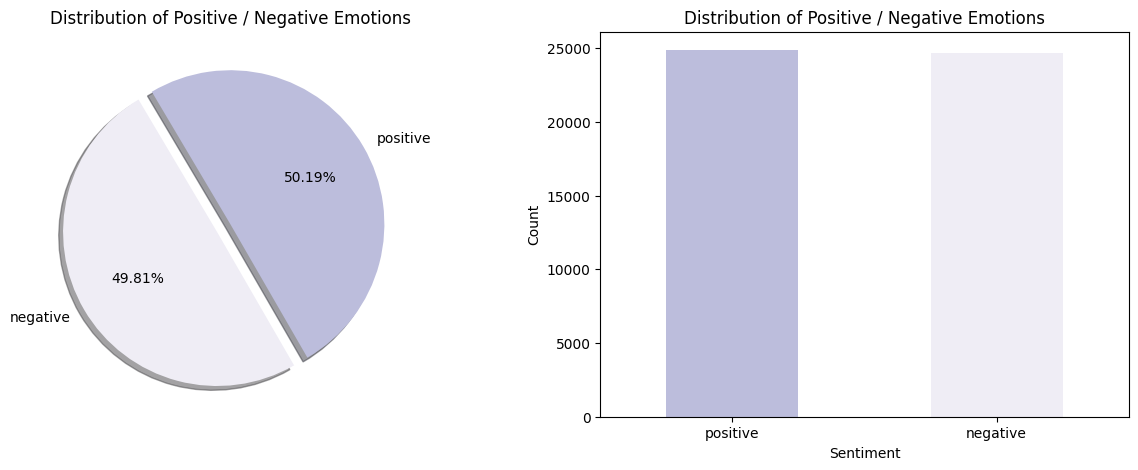

In [29]:
a, ax = plt.subplots(1, 2, figsize=(15, 5))
# Pie chart
df['sentiment'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.2f%%', ax=ax[0], shadow=True, startangle=300, colors=["#bcbddc", "#efedf5"])
ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')
# Countplot
df['sentiment'].value_counts().plot(kind='bar', ax=ax[1], color=["#bcbddc", "#efedf5"])
ax[1].set_title('Distribution of Positive / Negative Emotions')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Changing sentiment into binary

In [30]:
df.sentiment = [ 1 if each == "positive" else 0 for each in df.sentiment]

In [31]:
df

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49577,thought movie right good job creative original...,1
49578,bad plot bad dialogue bad acting idiotic direc...,0
49579,catholic taught parochial elementary school nu...,0
49580,going disagree previous comment side maltin on...,0


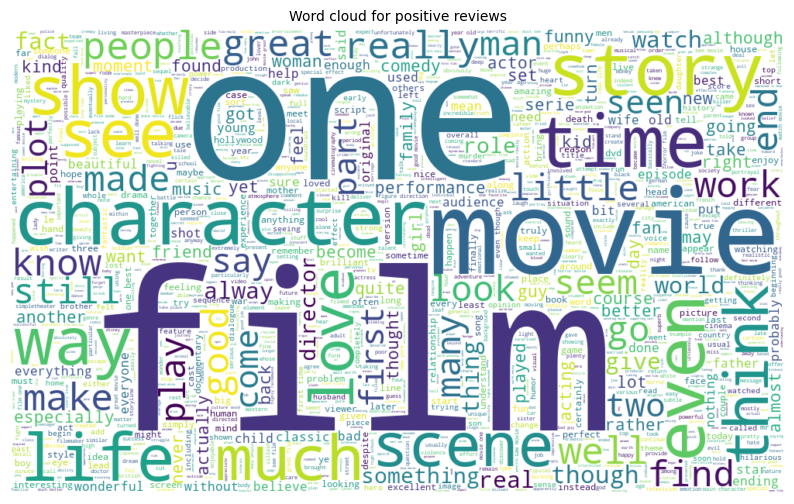

In [32]:
#word cloud for positive reviews
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1000, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 10)
plt.show()

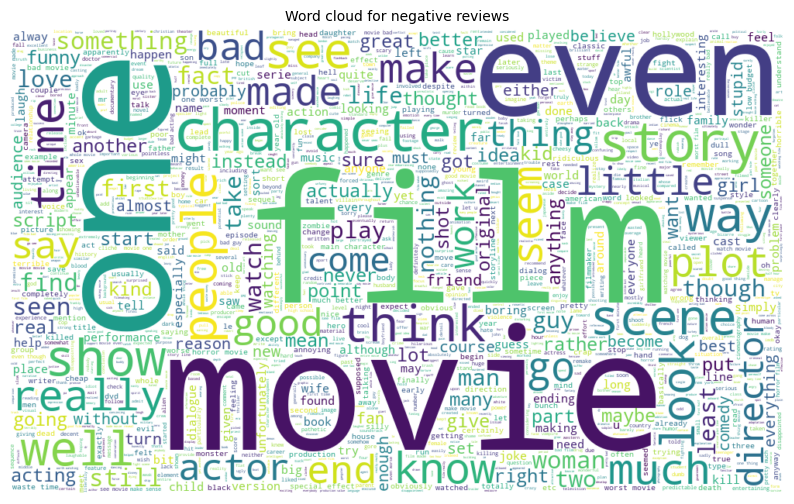

In [33]:
#word cloud for negative reviews
negative_data = df[df.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1000, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 10)
plt.show()

/var/folders/mh/wqcr2cx16h3grwmsnz9ky3yr0000gn/T/ipykernel_12869/3404439981.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
/var/folders/mh/wqcr2cx16h3grwmsnz9ky3yr0000gn/T/ipykernel_12869/3404439981.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,

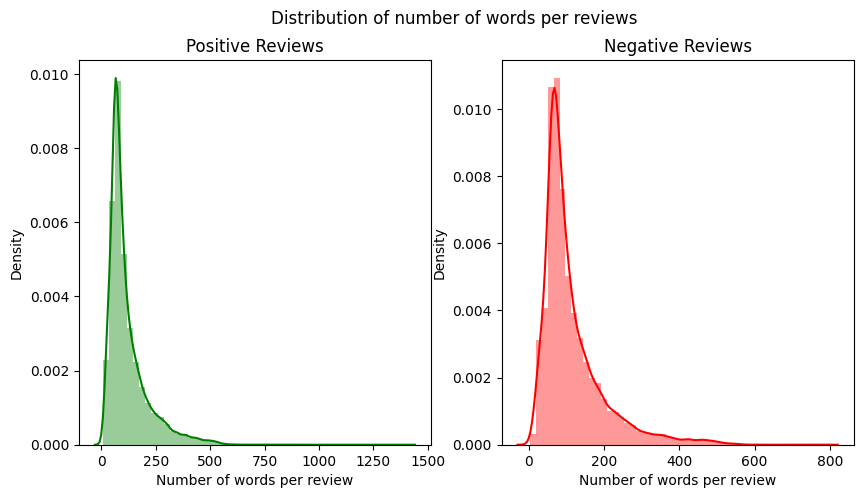

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

/var/folders/mh/wqcr2cx16h3grwmsnz9ky3yr0000gn/T/ipykernel_12869/3842632623.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
/var/folders/mh/wqcr2cx16h3grwmsnz9ky3yr0000gn/T/ipykernel_12869/3842632623.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

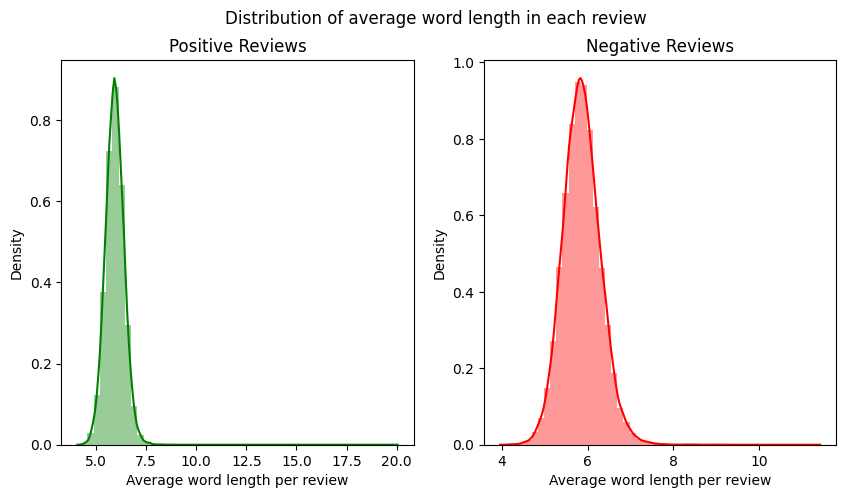

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.show()

In [36]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [37]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(12)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,98191
1,film,89128
2,one,52247
3,like,39447
4,would,30282
5,time,29108
6,good,28396
7,character,27339
8,get,24238
9,even,24080


In [38]:
most_common = most_common.sort_values('countv')

In [39]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

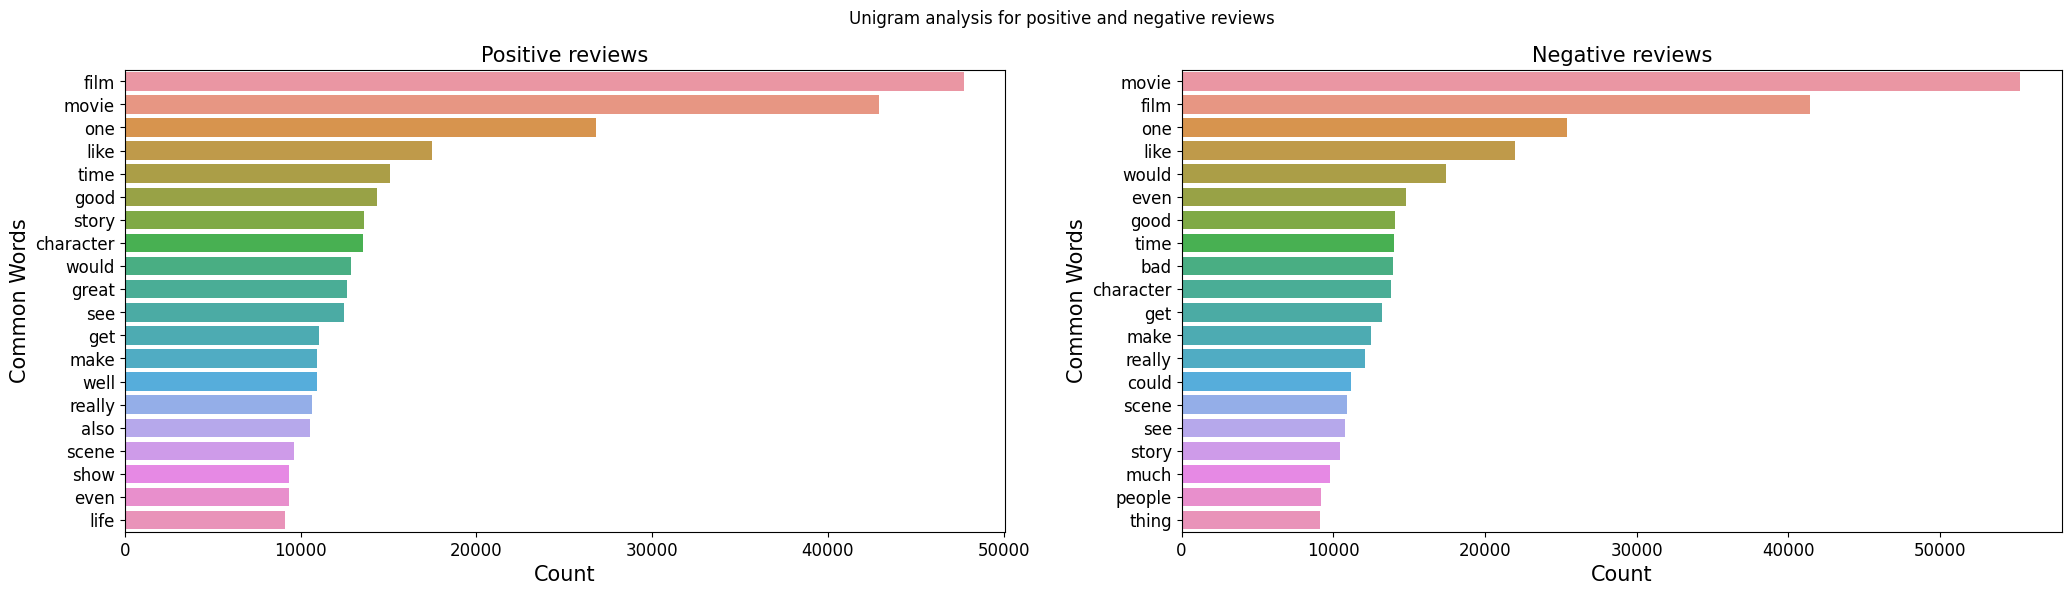

In [40]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,6))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews', fontsize=15)
ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Common Words', fontsize=15)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews', fontsize=15)
ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Common Words', fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

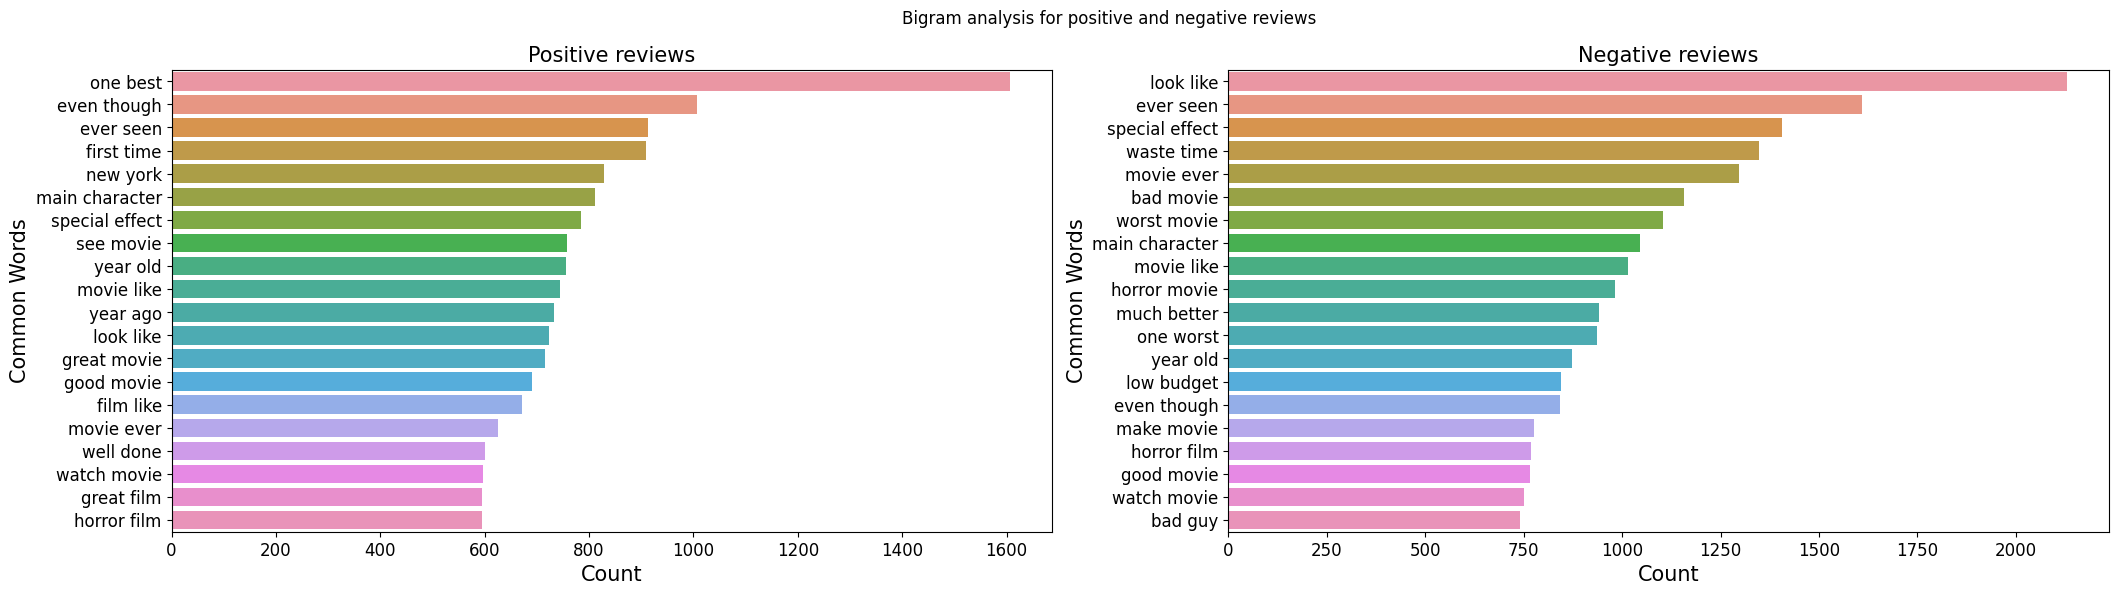

In [41]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,6))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews', fontsize=15)
ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Common Words', fontsize=15)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews', fontsize=15)
ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Common Words', fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

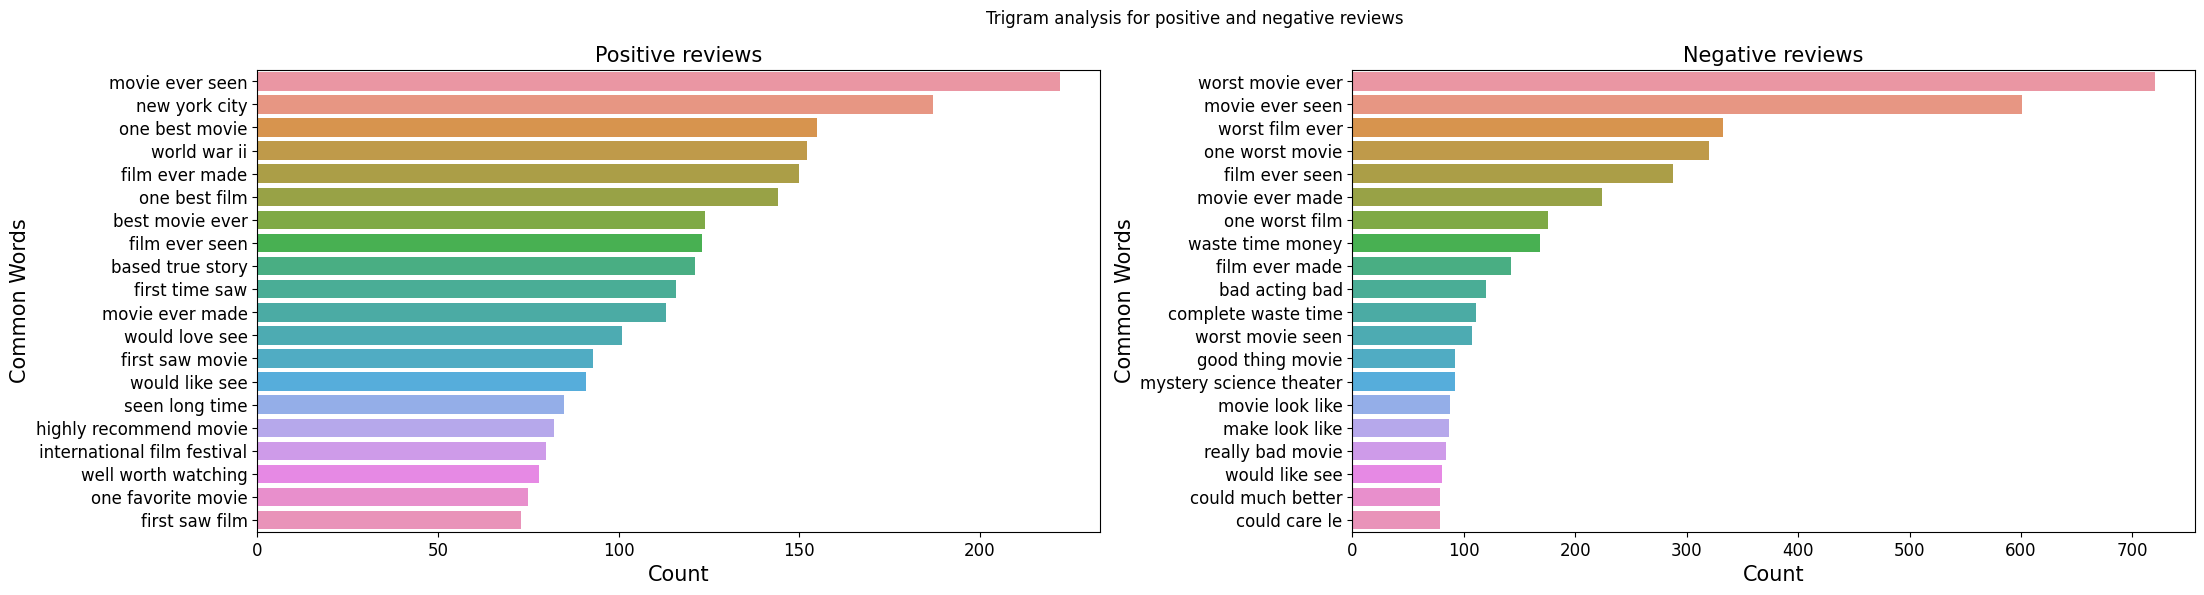

In [42]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,6))
plt.subplots_adjust(wspace=0.3)
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews', fontsize=15)
ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Common Words', fontsize=15)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews', fontsize=15)
ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Common Words', fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

## Modelling using Machine Learning

In [43]:
#splitting into train and test
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [44]:
#Vectorizing data
tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

#### Logistic Regression

In [45]:
print(ytest.value_counts())
print(ytrain.value_counts())

1    4978
0    4939
Name: sentiment, dtype: int64
1    19906
0    19759
Name: sentiment, dtype: int64


In [46]:
lr = LogisticRegression(max_iter=1000)
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))

f1_micro = f1_score(ytest, p1, average='micro')
print("Logistic Regression F1 Score (Micro Average): {:.2f}".format(f1_micro))

f1_macro = f1_score(ytest, p1, average='macro')
print("Logistic Regression F1 Score (Macro Average): {:.2f}".format(f1_macro))

Logistic Regression Accuracy : 88.94%
Logistic Regression F1 Score (Micro Average): 0.89
Logistic Regression F1 Score (Macro Average): 0.89


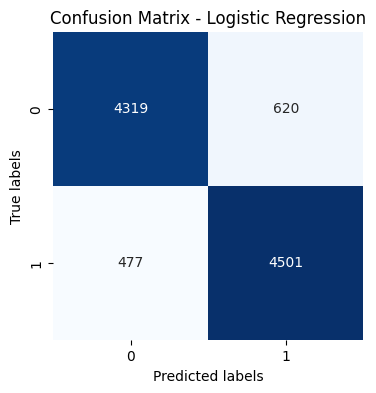

In [47]:
conf_matrix = confusion_matrix(ytest, p1)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Multinomial Naive Bayes

In [48]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))

f1_micro = f1_score(ytest, p2, average='micro')
print("Multinomial Naive Bayes F1 Score (Micro Average): {:.2f}".format(f1_micro))

f1_macro = f1_score(ytest, p2, average='macro')
print("Multinomial Naive Bayes F1 Score (Macro Average): {:.2f}".format(f1_macro))

Multinomial Naive Bayes Classifier Accuracy : 86.55%
Multinomial Naive Bayes F1 Score (Micro Average): 0.87
Multinomial Naive Bayes F1 Score (Macro Average): 0.87


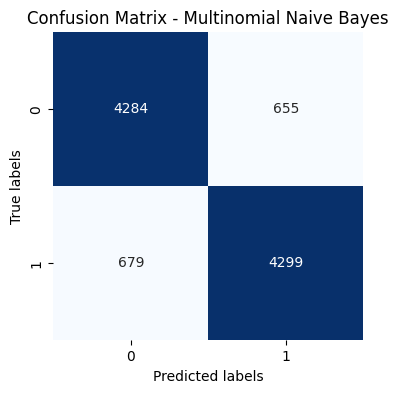

In [49]:
conf_matrix = confusion_matrix(ytest, p2)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

#### Linear SVM

In [50]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))

f1_micro = f1_score(ytest, p3, average='micro')
print("Linear SVC F1 Score (Micro Average): {:.2f}".format(f1_micro))

f1_macro = f1_score(ytest, p3, average='macro')
print("Linear SVC F1 Score (Macro Average): {:.2f}".format(f1_macro))

/Users/varun/DS/VirtualEnv/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear Support Vector Classifier Accuracy : 89.33%
Linear SVC F1 Score (Micro Average): 0.89
Linear SVC F1 Score (Macro Average): 0.89


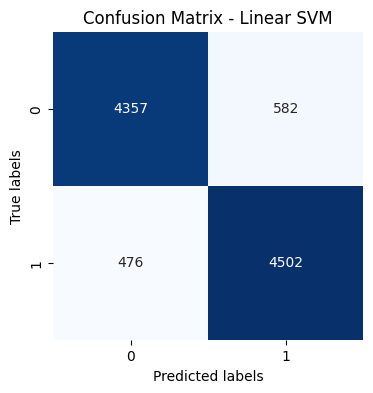

In [51]:
conf_matrix = confusion_matrix(ytest, p3)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Linear SVM")
plt.show()